`python3 -m pip install -U pandas plotly nbformat`

`pip install https://github.com/DCMLab/wavescapes/archive/refs/heads/johannes.zip`

In [97]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from wavescapes import Wavescape
from wavescapes.color import circular_hue
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm


from etl import get_dfts, get_mag_phase_mx, get_maj_min_coeffs, get_metadata, get_most_resonant, get_pcms, get_pcvs, get_ttms, test_dict_keys, get_center_of_mass, get_mean_resonance, add_to_metrics, get_partition_entropy, get_percentage_resonance
from utils import get_coeff, most_resonant2color, pitch_class_matrix_to_tritone, pitch_class_matrix_to_minor_major

## Settings

In [2]:
DEBUSSY_REPO = '.'
DATA_FOLDER = '~/DATA/debussy_figures/data'
DATA_FOLDER = './data/data'
EXAMPLE_FNAME = 'l000_etude'

## Loading metadata
Metadata for all pieces contained in the dataset.

In [3]:
metadata = get_metadata(DEBUSSY_REPO)
metadata.columns

Metadata for 67 files.


Index(['rel_paths', 'last_mc', 'last_mn', 'length_qb', 'length_qb_unfolded',
       'all_notes_qb', 'TimeSig', 'KeySig', 'label_count', 'composer',
       'workTitle', 'movementNumber', 'movementTitle', 'workNumber', 'poet',
       'lyricist', 'arranger', 'copyright', 'creationDate', 'mscVersion',
       'platform', 'source', 'translator', 'musescore', 'ambitus', 'comments',
       'composed_end', 'composed_start', 'originalFormat', 'pdf',
       'staff_1_ambitus', 'staff_1_instrument', 'staff_2_ambitus',
       'staff_2_instrument', 'staff_3_ambitus', 'staff_3_instrument',
       'transcriber', 'typesetter', 'year', 'median_recording',
       'qb_per_minute', 'sounding_notes_per_qb', 'sounding_notes_per_minute'],
      dtype='object')

The column `year` contains composition years as the middle between beginning and end  of the composition span.

In [4]:
metadata.year.head(10)

fnames
l000_etude                     1915.0
l000_soirs                     1917.0
l009_danse                     1880.0
l066-01_arabesques-premiere    1888.0
l066-02_arabesques-deuxieme    1891.0
l067_mazurka                   1890.0
l068_reverie                   1890.0
l069_tarentelle                1890.0
l070_ballade                   1890.0
l071_valse                     1890.0
Name: year, dtype: float64

Series `median_recording` contains median recording times in seconds, retrieved from the Spotify API. the Spotify API.

In [5]:
metadata.median_recording.head(10)

fnames
l000_etude                     272.5530
l000_soirs                     145.8265
l009_danse                     124.5995
l066-01_arabesques-premiere    240.7780
l066-02_arabesques-deuxieme    213.9330
l067_mazurka                   175.9130
l068_reverie                   265.4265
l069_tarentelle                331.5290
l070_ballade                   396.0200
l071_valse                     221.4500
Name: median_recording, dtype: float64

Columns mirroring a piece's activity are currently:
* `qb_per_minute`: the pieces' lengths (expressed as 'qb' = quarterbeats) normalized by the median recording times; a proxy for the tempo
* `sounding_notes_per_minute`: the summed length of all notes normalized by the piece's duration (in minutes)
* `sounding_notes_per_qb`: the summed length of all notes normalized by the piece's length (in qb)
Other measures of activity could be, for example, 'onsets per beat/second' or 'distinct pitch classes per beat/second'.

In [6]:
#px.scatter(fname2activity.reset_index(), x='qb_per_minute', y='sounding_notes_per_minute', hover_data=['fnames'], trendline='ols', title="Do faster pieces have more sounding notes per minute?")

## Loading Pitch Class Vectors (PCVs)
An `{fname -> pd.DataFrame}` dictionary where each `(NX12)` DataFrame contains the absolute durations (expressed in quarter nots) of the 12 chromatic pitch classes for the `N` slices of length = 1 quarter note that make up the piece `fname`. The IntervalIndex reflects each slice's position in the piece. Set `pandas` to False to retrieve NumPy arrays without the IntervalIndex and column names.

In [7]:
pcvs = get_pcvs(DEBUSSY_REPO, pandas=True)
test_dict_keys(pcvs, metadata)
pcvs[EXAMPLE_FNAME].head(5)

Couldn't find matrices for the following files:
['l066-01_arabesques-premiere', 'l066-02_arabesques-deuxieme'].


,0,1,2,3,4,5,6,7,8,9,10,11
iv,,,,,,,,,,,,
"[0.0, 1.0)",0.167,0.0,0.0,0.334,0.0,0.000,0.0,0.0,1.334,0.0,0.167,0.0
"[1.0, 2.0)",0.167,0.0,0.0,0.334,0.0,0.334,0.0,0.0,1.167,0.0,0.000,0.0
"[2.0, 3.0)",0.167,0.0,0.0,0.334,0.0,0.334,0.0,0.0,0.167,0.0,0.000,0.0
"[3.0, 4.0)",0.167,0.0,0.0,0.334,0.0,0.334,0.0,0.0,0.167,0.0,0.000,0.0
"[4.0, 5.0)",0.167,0.0,0.0,0.334,0.0,0.334,0.0,0.0,1.167,0.0,0.000,0.0


## Loading Pitch Class Matrices
An `{fname -> np.array}` dictionary where each `(NxNx12)` array contains the aggregated PCVs for all segments that make up a piece. The square matrices contain values only in the upper right triangle, with the lower left beneath the diagonal is filled with zeros. The values are arranged such that row 0 correponds to the original PCV, row 1 the aggregated PCVs for all segments of length = 2 quarter notes, etc. For getting the segment reaching from slice 3 to 5 (including), i.e. length 3, the coordinates are `(2, 5)` (think x = 'length - 1' and y = index of the last slice included). The following example shows the upper left 3x3 submatrix where the first three entries (which are PCVs of size 12) correspond to the first three PCVs above, the first three of the second row to their sums padded with a 0-PCV, and the first three of the third row corresponding to the sum of row 0, padded with another 0-PCV.

In [8]:
pcms = get_pcms(DEBUSSY_REPO)
test_dict_keys(pcms, metadata)
pcms[EXAMPLE_FNAME][:3,:3]

Couldn't find matrices for the following files:
['l066-01_arabesques-premiere', 'l066-02_arabesques-deuxieme'].


array([[[0.167, 0.   , 0.   , 0.334, 0.   , 0.   , 0.   , 0.   , 1.334,
         0.   , 0.167, 0.   ],
        [0.167, 0.   , 0.   , 0.334, 0.   , 0.334, 0.   , 0.   , 1.167,
         0.   , 0.   , 0.   ],
        [0.167, 0.   , 0.   , 0.334, 0.   , 0.334, 0.   , 0.   , 0.167,
         0.   , 0.   , 0.   ]],

       [[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   ],
        [0.334, 0.   , 0.   , 0.668, 0.   , 0.334, 0.   , 0.   , 2.501,
         0.   , 0.167, 0.   ],
        [0.334, 0.   , 0.   , 0.668, 0.   , 0.668, 0.   , 0.   , 1.334,
         0.   , 0.   , 0.   ]],

       [[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   ],
        [0.501, 0.   , 0.   , 1.002, 0.   , 0.668, 0.   , 0.   , 2.668,
         0.   , 0.167, 0.   ]]])

## Loading Discrete Fourier Transforms
`{fname -> np.array}` containing `(NxNx7)` complex matrices. For instance, here's the first element, a size 7 complex vector with DFT coefficients 0 through 6:

In [9]:
dfts = get_dfts(DEBUSSY_REPO)
test_dict_keys(dfts, metadata)
dfts[EXAMPLE_FNAME][0,0]

Couldn't find matrices for the following files:
['l066-01_arabesques-premiere', 'l066-02_arabesques-deuxieme'].


array([ 2.002 +0.00000000e+00j, -0.4165+9.65904131e-01j,
       -0.9175-1.01065165e+00j,  1.334 +3.34000000e-01j,
       -0.2495+1.01065165e+00j, -0.4165-1.63390413e+00j,
        1.334 +1.11022302e-16j])

You can view the 7 complex numbers as magnitude-phase pairs

In [10]:
get_coeff(dfts[EXAMPLE_FNAME], 0, 0)

array([[ 2.  ,  0.  ],
       [ 1.05,  1.98],
       [ 1.36, -2.31],
       [ 1.38,  0.25],
       [ 1.04,  1.81],
       [ 1.69, -1.82],
       [ 1.33,  0.  ]])

or even as strings where the numbers are rounded and angles are shown in degrees:

In [11]:
get_coeff(dfts[EXAMPLE_FNAME], 0, 0,deg=True)

array([['2.0+0°'],
       ['1.05+247°'],
       ['1.36+132°'],
       ['1.38+346°'],
       ['1.04+256°'],
       ['1.69+104°'],
       ['1.33+0°']], dtype='<U9')

## Loading magnitude-phase matrices
`{fname -> np.array}` where each of the `(NxNx6x2)` matrices contains the 6 relevant DFT coefficients converted into magnitude-phase pairs where the magnitudes have undergone at least one normalization, i.e. are all within [0,1]. The files have been pre-computed and are loaded from g-zipped pickled matrices.

The parameter `normalization` allows for the values `('0c', 'post_norm', 'max_weighted', 'max')`.

In [7]:
mag_phase_mx_dict = get_mag_phase_mx(DATA_FOLDER, normalization='0c', indulge_prototypes=True)
test_dict_keys(mag_phase_mx_dict, metadata)

print(f"Matrices have the shape NxNx6x2, where the last dimension holds magnitude and phase for each of the 6 coefficients.\n"
      f"E.g. '{EXAMPLE_FNAME}': {mag_phase_mx_dict[EXAMPLE_FNAME].shape}")


Couldn't find matrices for the following files:
['l066-01_arabesques-premiere', 'l066-02_arabesques-deuxieme', 'l099_cahier', 'l111-03_images_poissons', 'l117-11_preludes_danse', 'l136-12_etudes_accords'].
Matrices have the shape NxNx6x2, where the last dimension holds magnitude and phase for each of the 6 coefficients.
E.g. 'l000_etude': (284, 284, 6, 2)


In [8]:
mag_phase_mx_dict[EXAMPLE_FNAME][0,0]

array([[ 5.38214271e-01,  1.97790855e+00],
       [ 7.49750250e-01, -2.30792065e+00],
       [ 8.33166833e-01,  2.45331397e-01],
       [ 7.49750250e-01,  1.81282734e+00],
       [ 8.71880604e-01, -1.82039166e+00],
       [ 6.66333666e-01,  8.32251143e-17]])

## Loading most resonant DFT coefficients
This cell depends on the previously loaded magnitude-phase matrices, i.e. a conscious choice of a normalization method has been made above.

`get_most_resonant` returns three `{fname -> nd.array}` dictionaries where for each piece, the three `(NxN)` matrices correspond to

1. the index between 0 and 5 of the most resonant of the six DFT coefficient 1 through 6
2. its magnitude
3. the inverse entropy of the 6 magnitudes

In [80]:
max_coeffs, max_mags, inv_entropies = get_most_resonant(mag_phase_mx_dict)
np.stack((max_coeffs[EXAMPLE_FNAME][:3,:3],
max_mags[EXAMPLE_FNAME][:3,:3],
inv_entropies[EXAMPLE_FNAME][:3,:3]))

C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\scipy\stats\_entropy.py:72: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\ludov\anaconda3\en

array([[[4.        , 3.        , 3.        ],
        [0.        , 3.        , 3.        ],
        [0.        , 0.        , 3.        ]],

       [[0.8718806 , 1.        , 1.        ],
        [0.        , 0.87487512, 1.        ],
        [0.        , 0.        , 0.8999201 ]],

       [[0.        , 1.        , 0.82077101],
        [       nan, 0.        , 1.        ],
        [       nan,        nan, 0.        ]]])

# Center of mass

Computing the center of mass of each coefficient for all the pieces. Uses `mag_phase_mx_dict` as input and outputs the vertical center of mass as a fraction of the height of the wavescape. `get_center_of_mass` returns one `{fname -> list}` dictionary containing the 6 np.floats, one for each coefficient. 

In [61]:
center_of_masses = get_center_of_mass(mag_phase_mx_dict)
test_dict_keys(center_of_masses, metadata)
print(f"The example center of mass list has shape {len(center_of_masses[EXAMPLE_FNAME])}.")
center_of_masses[EXAMPLE_FNAME]

Couldn't find matrices for the following files:
['l066-01_arabesques-premiere', 'l066-02_arabesques-deuxieme', 'l099_cahier', 'l111-03_images_poissons', 'l117-11_preludes_danse', 'l136-12_etudes_accords'].
The example center of mass list has shape 6.


[0.26600092984200885,
 0.21161124832720876,
 0.2431548982901923,
 0.2216396770564771,
 0.2852747163984566,
 0.21447410060868968]

In [65]:
cols = [f"center_of_mass_{i}" for i in range(1,7)]
metadata_metrics = metadata.copy()


metadata_metrics = add_to_metrics(metadata_metrics, center_of_masses, cols)
metadata_metrics.head(1)


,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,TimeSig,KeySig,label_count,composer,...,median_recording,qb_per_minute,sounding_notes_per_qb,sounding_notes_per_minute,center_of_mass_1,center_of_mass_2,center_of_mass_3,center_of_mass_4,center_of_mass_5,center_of_mass_6
l000_etude,MS3,73,71,284.0,284.0,959.25,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,Claude Debussy,...,272.553,62.51995,3.377641,211.169938,0.266001,0.211611,0.243155,0.22164,0.285275,0.214474


In [49]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

#fig = make_subplots(rows=3, cols=2)

# for i in range(0, 6):
#     fig.append_trace(
#         go.Scatter(
#             x=metadata_metrics['year'],
#             y=metadata_metrics[f'center_of_mass_{i+1}'],
#             mode="markers",
#             text=metadata_metrics.index,
#         ),
#         row=i//2 + 1,
#         col=i%2 + 1,
#     )

#fig.update_layout(height=800, width=1200, title_text="Center of Mass")
#fig.show()


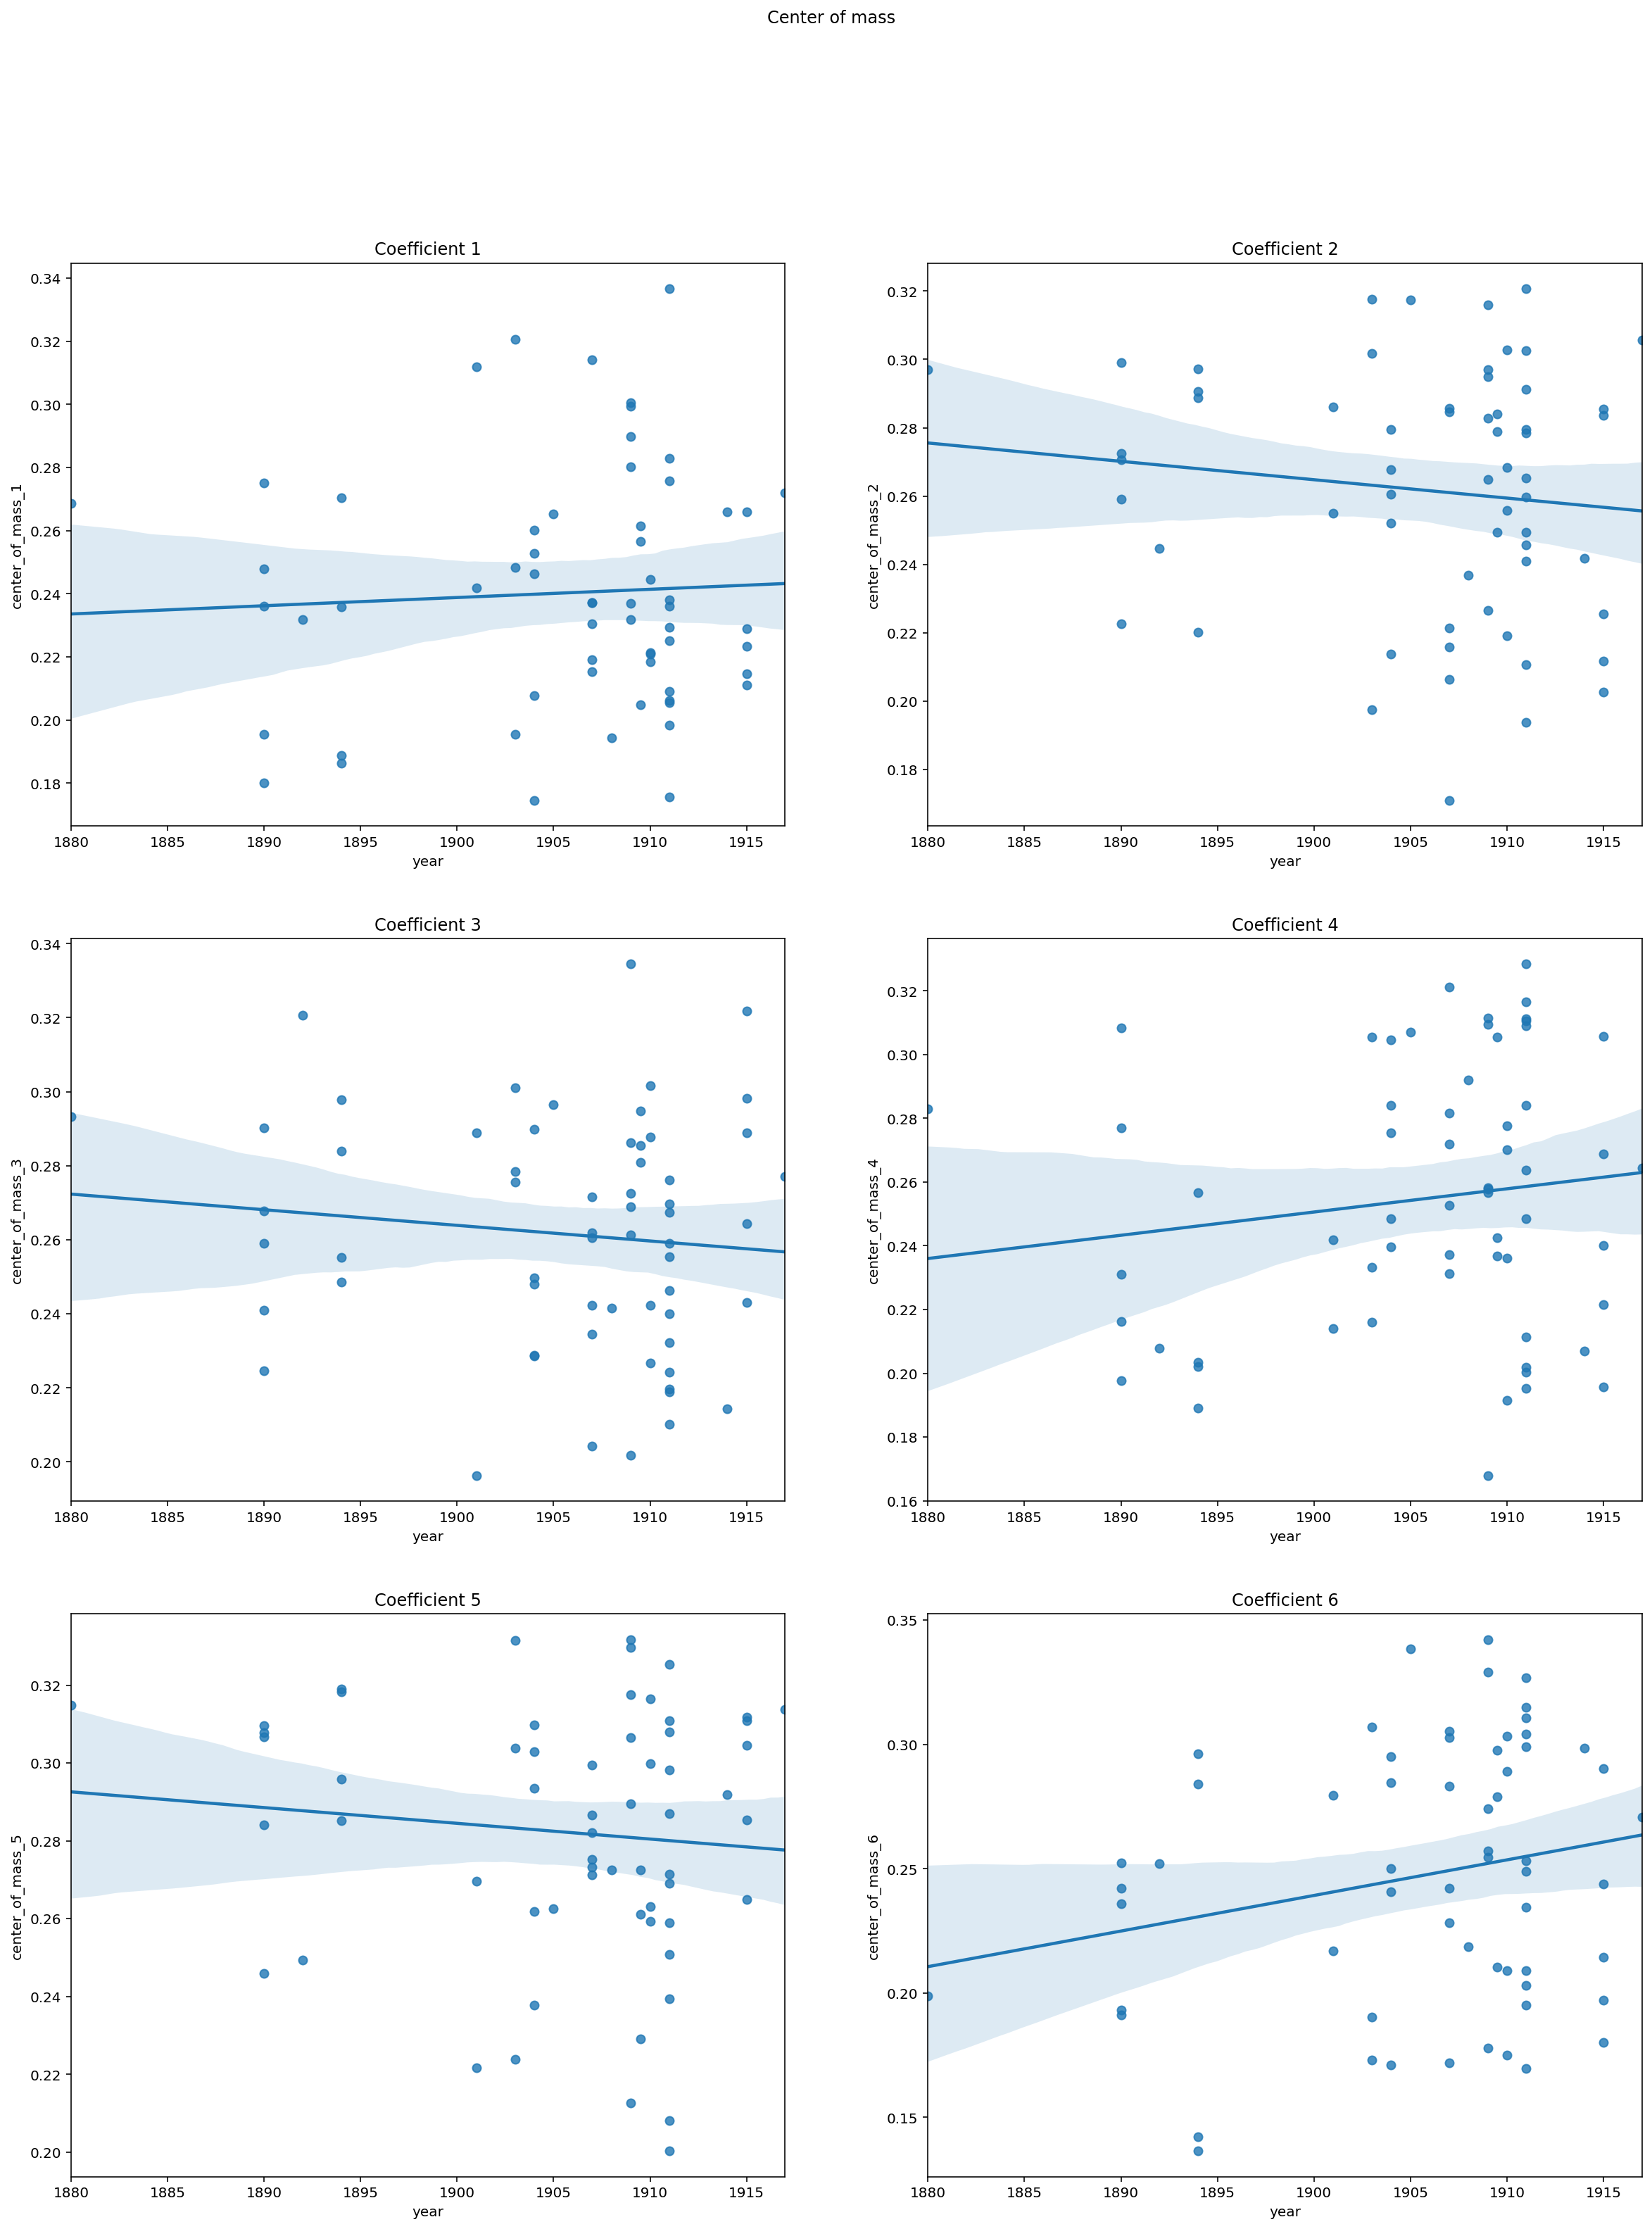

In [66]:
fig, axs = plt.subplots(3,2, figsize=(20,25))
axs = axs.flatten()

fig.suptitle('Center of mass')
columns_com = []

for i in range(1,7):
    axs[i-1].set_title(f"Coefficient {i}")
    columns_com.append(f"center_of_mass_{i}")
    sns.regplot(x='year', y=f"center_of_mass_{i}", data=metadata_metrics, ax=axs[i-1])
    
plt.savefig('figures/center_of_mass.png')

In [67]:
metadata_sm = metadata_metrics[metadata_metrics['center_of_mass_1'].notnull()]
scaler = StandardScaler()
metadata_sm[columns_com] = scaler.fit_transform(metadata_sm[columns_com])
for col in columns_com:
    y = metadata_sm[col]
    X = metadata_sm[['year', 'last_mc']]
    X = sm.add_constant(X)
    results = sm.OLS(y, X).fit()
    #print(results.summary())

# other method: group early and late pieces

C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



# Mean Resonance

Same concept as above but this time it is not weighted by the height

In [68]:
mean_resonances = get_mean_resonance(mag_phase_mx_dict)
test_dict_keys(mean_resonances, metadata)
print(f"The example mean resonance has shape {len(mean_resonances[EXAMPLE_FNAME])}.")
mean_resonances[EXAMPLE_FNAME]

Couldn't find matrices for the following files:
['l066-01_arabesques-premiere', 'l066-02_arabesques-deuxieme', 'l099_cahier', 'l111-03_images_poissons', 'l117-11_preludes_danse', 'l136-12_etudes_accords'].
The example mean resonance has shape 6.


array([0.05352486, 0.0653218 , 0.10388608, 0.15191741, 0.15174701,
       0.06172378])

In [69]:
cols = [f"mean_resonances_{i}" for i in range(1,7)]
metadata_metrics = add_to_metrics(metadata_metrics, mean_resonances, cols)
metadata_metrics.head(1)

,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,TimeSig,KeySig,label_count,composer,...,center_of_mass_3,center_of_mass_4,center_of_mass_5,center_of_mass_6,mean_resonances_1,mean_resonances_2,mean_resonances_3,mean_resonances_4,mean_resonances_5,mean_resonances_6
l000_etude,MS3,73,71,284.0,284.0,959.25,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,Claude Debussy,...,0.243155,0.22164,0.285275,0.214474,0.053525,0.065322,0.103886,0.151917,0.151747,0.061724


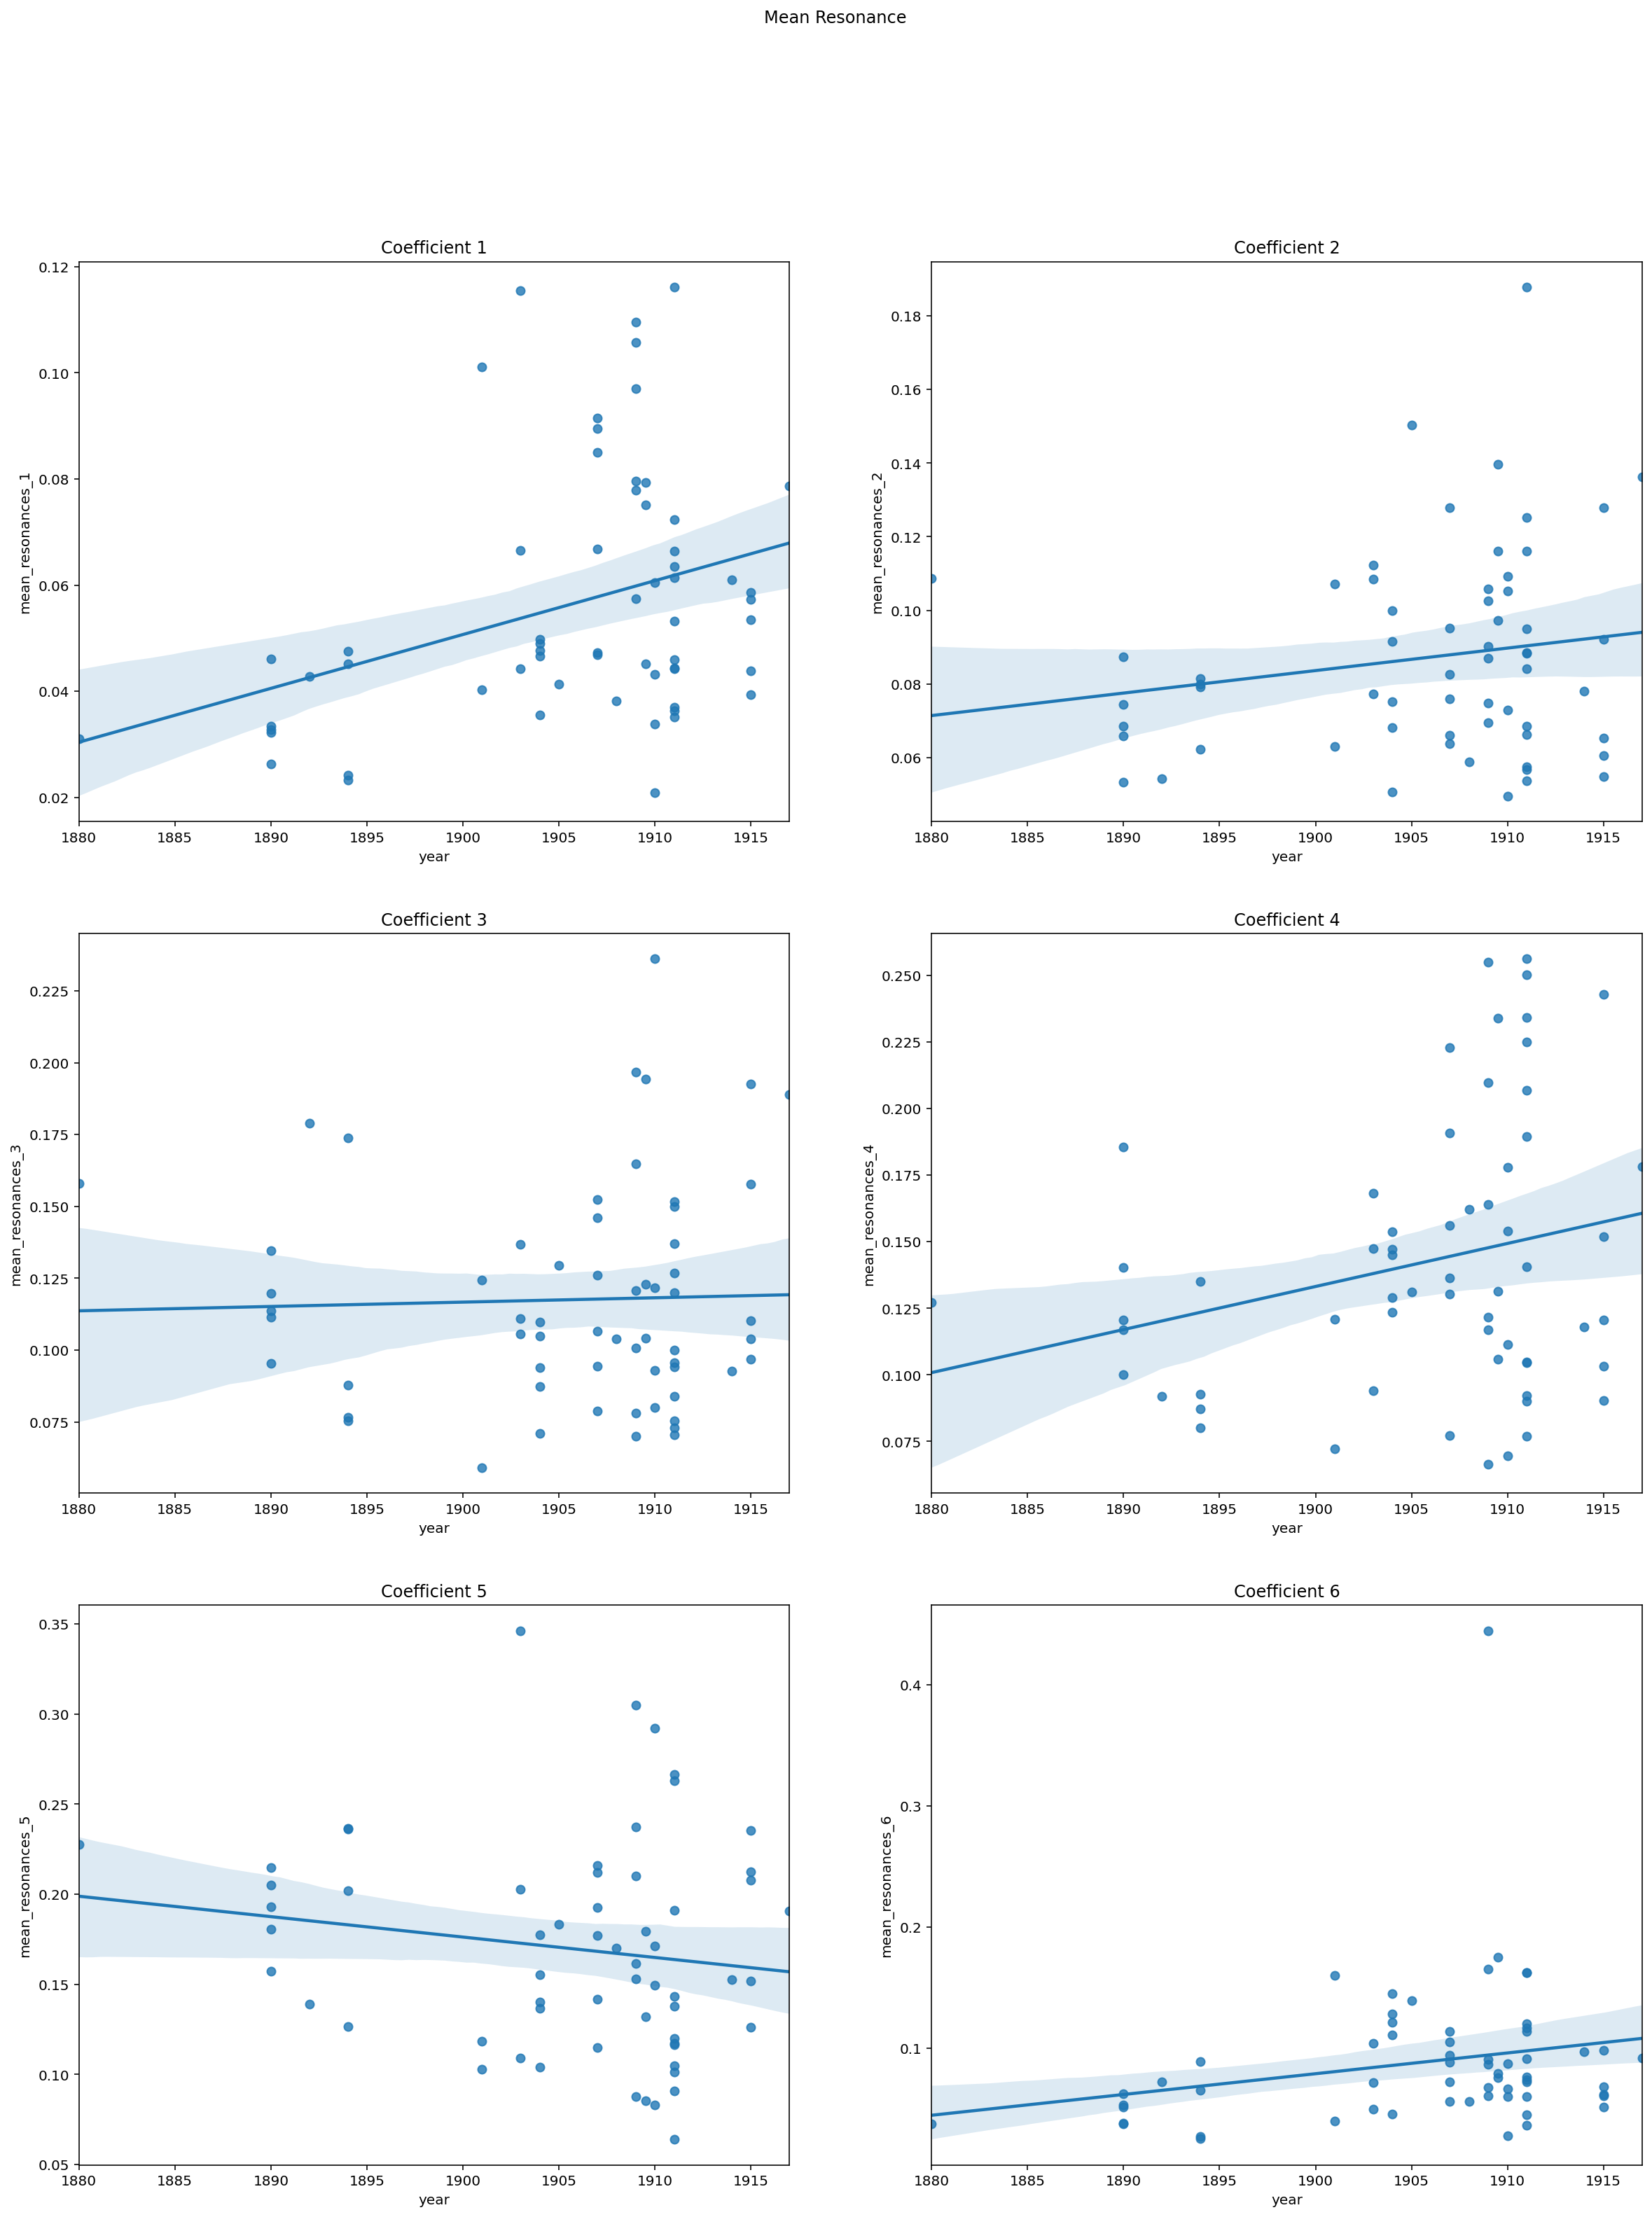

In [117]:
fig, axs = plt.subplots(3,2, figsize=(20,25))
axs = axs.flatten()

fig.suptitle('Mean Resonance')
columns_com = []

for i in range(1,7):
    axs[i-1].set_title(f"Coefficient {i}")
    columns_com.append(f"mean_resonances_{i}")
    sns.regplot(x='year', y=f"mean_resonances_{i}", data=metadata_metrics, ax=axs[i-1])
    
plt.savefig('figures/mean_resonance.png')

# Prevalence of each coefficient

In [81]:
partition_entropy = get_partition_entropy(max_coeffs)
test_dict_keys(partition_entropy, metadata)
#print(f"The example partition_entropy has shape {len(mean_resonances[EXAMPLE_FNAME])}.")
partition_entropy[EXAMPLE_FNAME]

Couldn't find matrices for the following files:
['l066-01_arabesques-premiere', 'l066-02_arabesques-deuxieme', 'l099_cahier', 'l111-03_images_poissons', 'l117-11_preludes_danse', 'l136-12_etudes_accords'].


0.1305336489210779

In [90]:
cols = 'partition_entropy'
metadata_metrics = add_to_metrics(metadata_metrics, partition_entropy, cols)
metadata_metrics.head(1)

,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,TimeSig,KeySig,label_count,composer,...,center_of_mass_4,center_of_mass_5,center_of_mass_6,mean_resonances_1,mean_resonances_2,mean_resonances_3,mean_resonances_4,mean_resonances_5,mean_resonances_6,partition_entropy
l000_etude,MS3,73,71,284.0,284.0,959.25,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,Claude Debussy,...,0.22164,0.285275,0.214474,0.053525,0.065322,0.103886,0.151917,0.151747,0.061724,0.130534


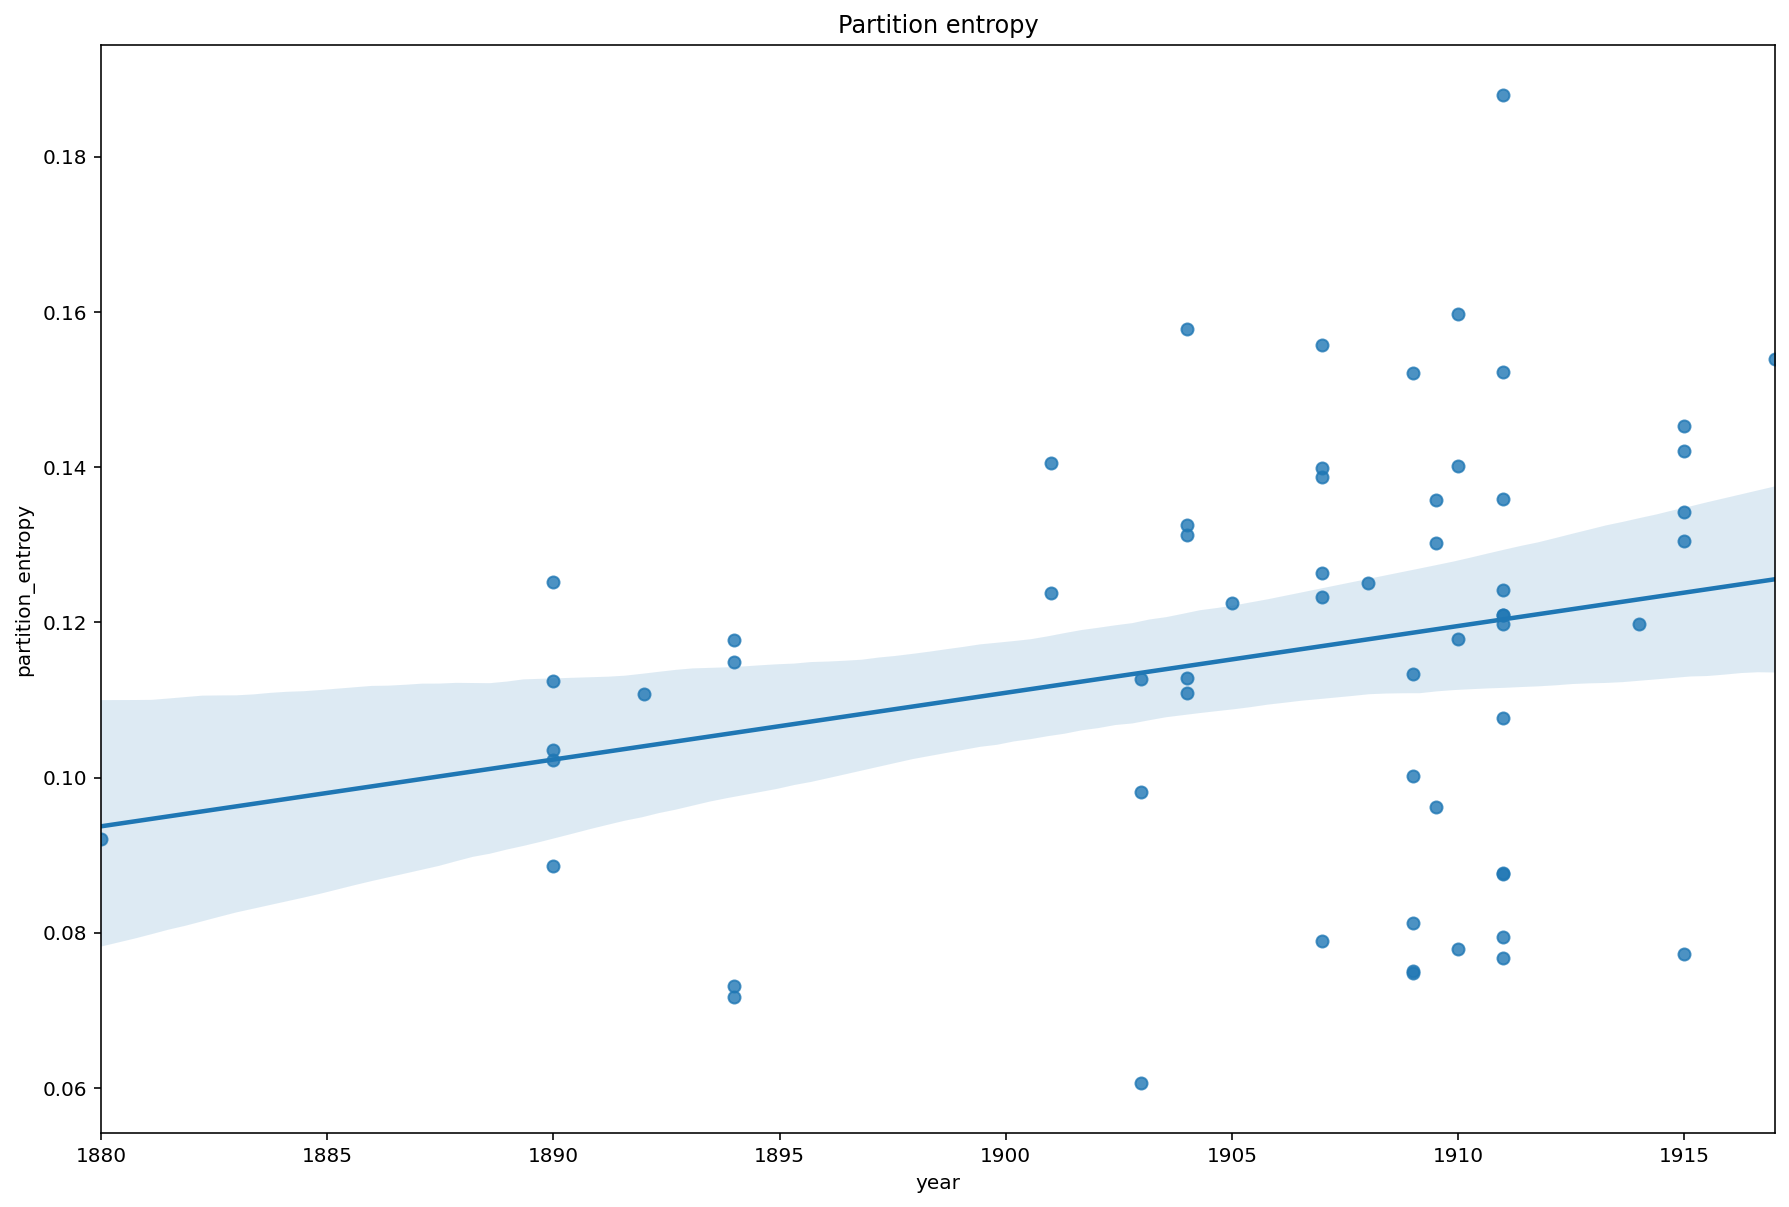

In [93]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
plt.title("Partition entropy")
sns.regplot(x='year', y='partition_entropy', data=metadata_metrics)
plt.savefig('figures/partition_entropy.png')

In [96]:
metadata_sm = metadata_metrics[metadata_metrics['partition_entropy'].notnull()]
scaler = StandardScaler()
metadata_sm['partition_entropy'] = scaler.fit_transform(np.array(metadata_sm['partition_entropy']).reshape(-1, 1))
y = metadata_sm['partition_entropy']
X = metadata_sm[['year', 'last_mc']]
X = sm.add_constant(X)
results = sm.OLS(y, X).fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:      partition_entropy   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     2.024
Date:                Fri, 18 Feb 2022   Prob (F-statistic):              0.141
Time:                        18:26:53   Log-Likelihood:                -84.498
No. Observations:                  61   AIC:                             175.0
Df Residuals:                      58   BIC:                             181.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -61.2399     32.386     -1.891      0.0

C:\Users\ludov\anaconda3\envs\ada\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only



# Percentage of resonance of the coefficients


In [107]:
percentage_resonance = get_percentage_resonance(max_coeffs)
test_dict_keys(percentage_resonance, metadata)
print(f"The example percentage resonance has shape {percentage_resonance[EXAMPLE_FNAME].shape}.")
percentage_resonance[EXAMPLE_FNAME]

Couldn't find matrices for the following files:
['l066-01_arabesques-premiere', 'l066-02_arabesques-deuxieme', 'l099_cahier', 'l111-03_images_poissons', 'l117-11_preludes_danse', 'l136-12_etudes_accords'].
The example percentage resonance has shape (6,).


array([0.49846261, 0.00101666, 0.07786154, 0.16114114, 0.25954672,
       0.00197134])

In [108]:
cols = [f"percentage_resonances_{i}" for i in range(1,7)]
metadata_metrics = add_to_metrics(metadata_metrics, percentage_resonance, cols)
metadata_metrics.head(1)

,rel_paths,last_mc,last_mn,length_qb,length_qb_unfolded,all_notes_qb,TimeSig,KeySig,label_count,composer,...,mean_resonances_4,mean_resonances_5,mean_resonances_6,partition_entropy,percentage_resonances_1,percentage_resonances_2,percentage_resonances_3,percentage_resonances_4,percentage_resonances_5,percentage_resonances_6
l000_etude,MS3,73,71,284.0,284.0,959.25,1: 4/4,"1: -4, 7: 0, 9: -5, 38: 0, 42: -4, 48: -3, 57:...",0,Claude Debussy,...,0.151917,0.151747,0.061724,0.130534,0.498463,0.001017,0.077862,0.161141,0.259547,0.001971


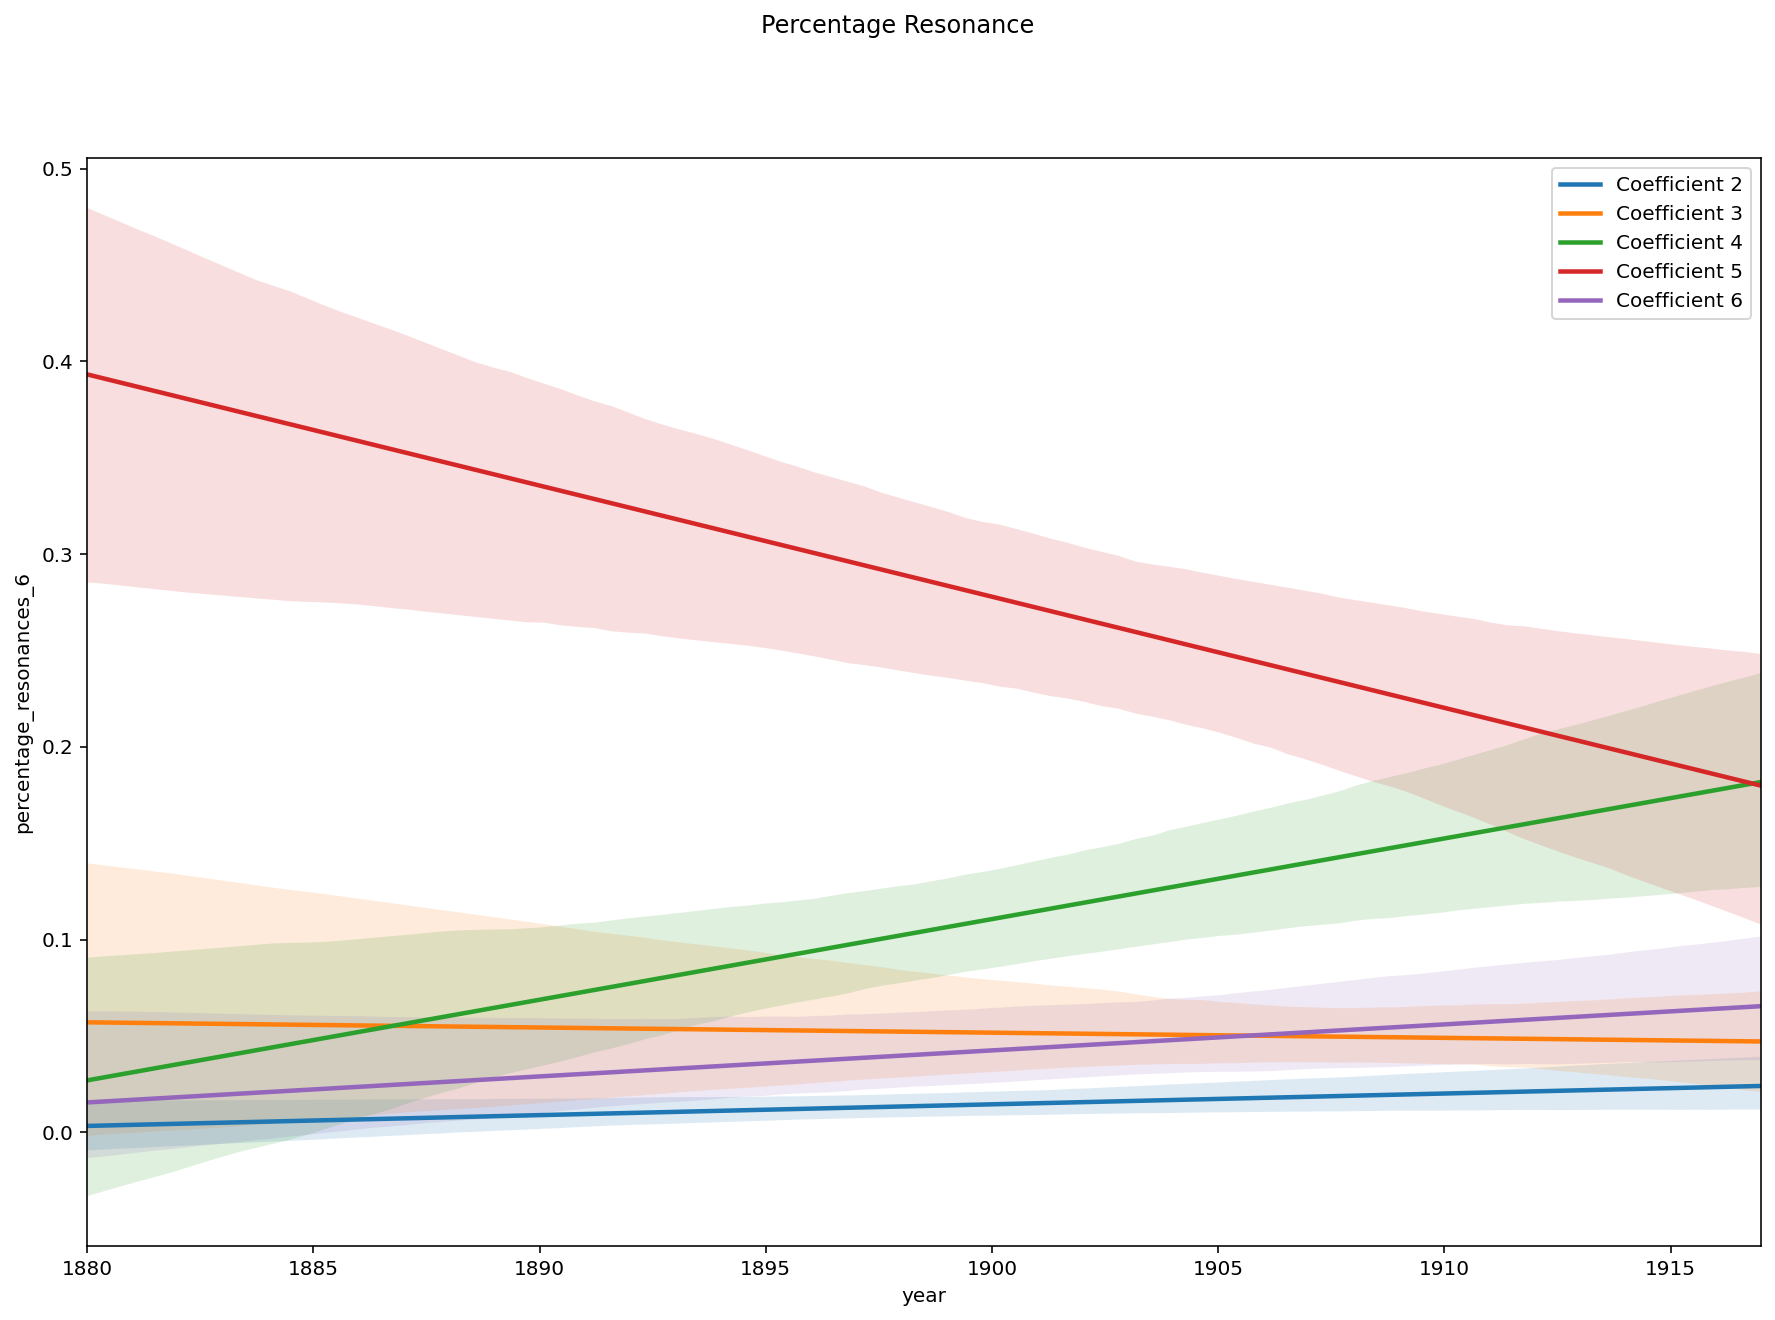

In [116]:
fig, axs = plt.subplots(1,1, figsize=(15,10))

fig.suptitle('Percentage Resonance')

for i in range(2,7):
    sns.regplot(x='year', y=f"percentage_resonances_{i}", data=metadata_metrics, scatter=False, label=f"Coefficient {i}")
    
plt.legend()
plt.savefig('figures/percentage_resonance.png')

## Loading tritone-ness matrices

In [62]:
ttms = get_ttms(DEBUSSY_REPO)
test_dict_keys(ttms, metadata)
print(f"The example tritone-ness matrix has shape {ttms[EXAMPLE_FNAME].shape}.")
ttms[EXAMPLE_FNAME][:6, :6]

Couldn't find matrices for the following files:
['l066-01_arabesques-premiere', 'l066-02_arabesques-deuxieme'].
The example tritone-ness matrix has shape (284, 284, 1).


array([[[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]])

## Loading major & minor coefficients

In [63]:
maj_min_coeffs = get_maj_min_coeffs(DEBUSSY_REPO)
test_dict_keys(maj_min_coeffs, metadata)
print(f"The example maj_min_coeffs have the shape {maj_min_coeffs[EXAMPLE_FNAME].shape}.")
maj_min_coeffs[EXAMPLE_FNAME][:3, :3]

## Minimal example for drawing a wavescape

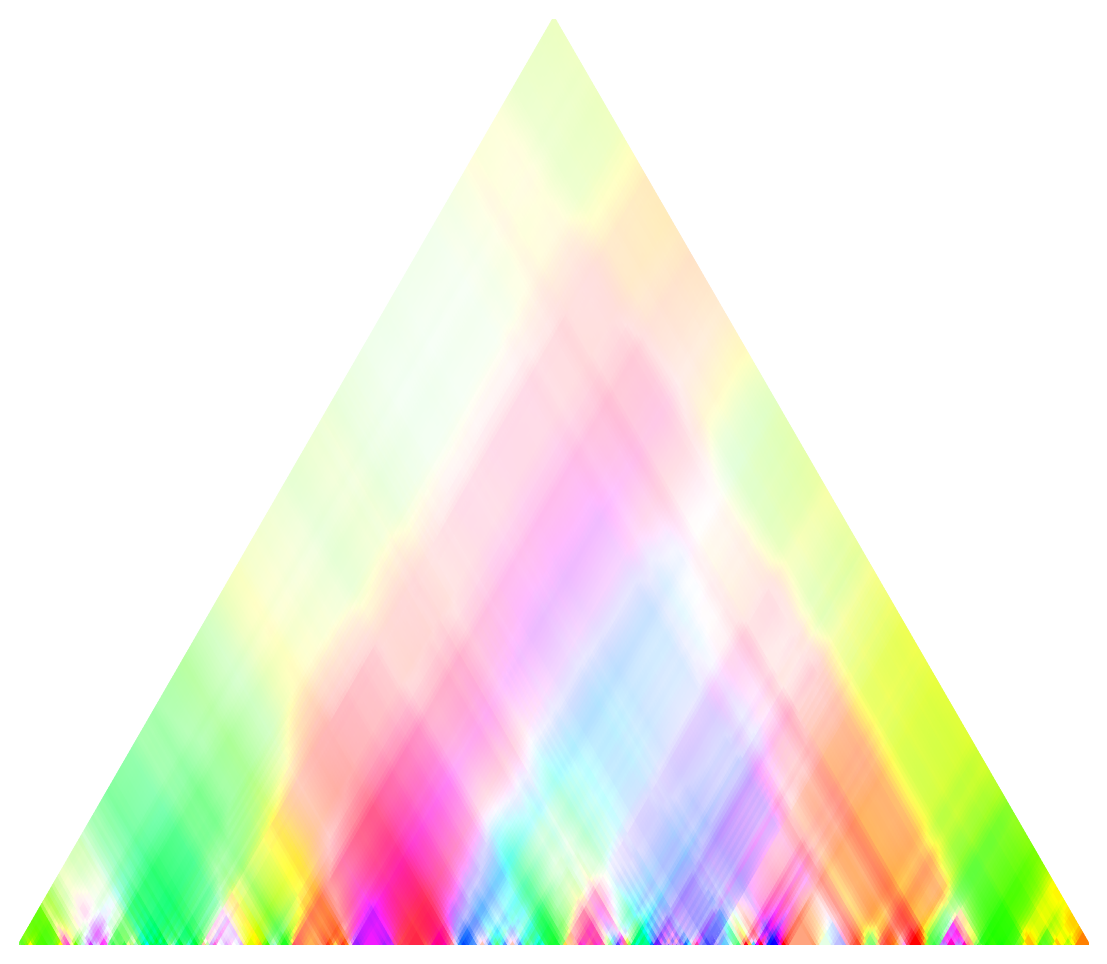

In [17]:
coeff_4_colors = circular_hue(mag_phase_mx_dict[EXAMPLE_FNAME][..., 3, :])
length = coeff_4_colors.shape[0]
width = 500 if length <= 250 else 2 * length
ws = Wavescape(coeff_4_colors, width=width)
ws.draw()

## Drawing a summary wavescapes

In [18]:
max_coeff, max_mag, inv_entropy = max_coeffs[EXAMPLE_FNAME], max_mags[EXAMPLE_FNAME], inv_entropies[EXAMPLE_FNAME]

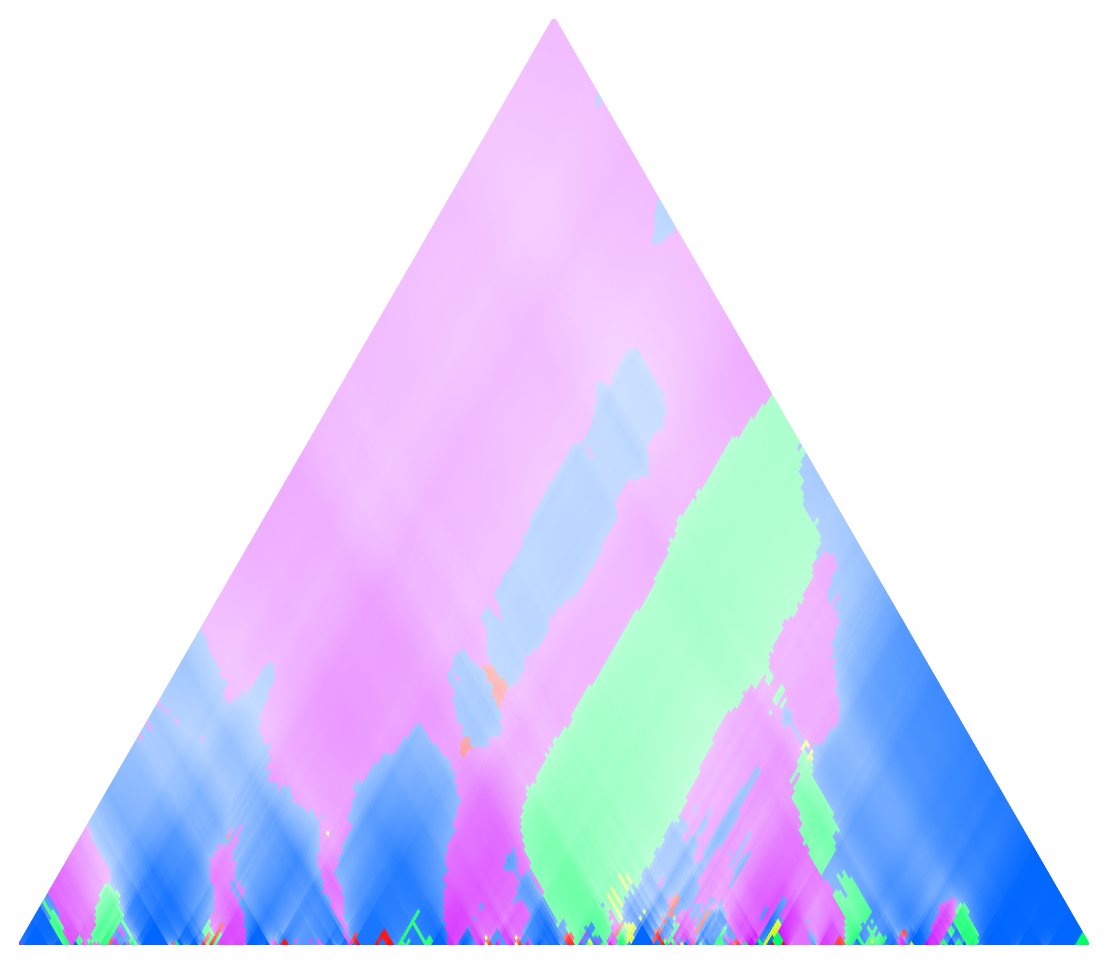

In [21]:
summary_colors = most_resonant2color(max_coeff, max_mag)
ws = Wavescape(summary_colors, width=width)
ws.draw()

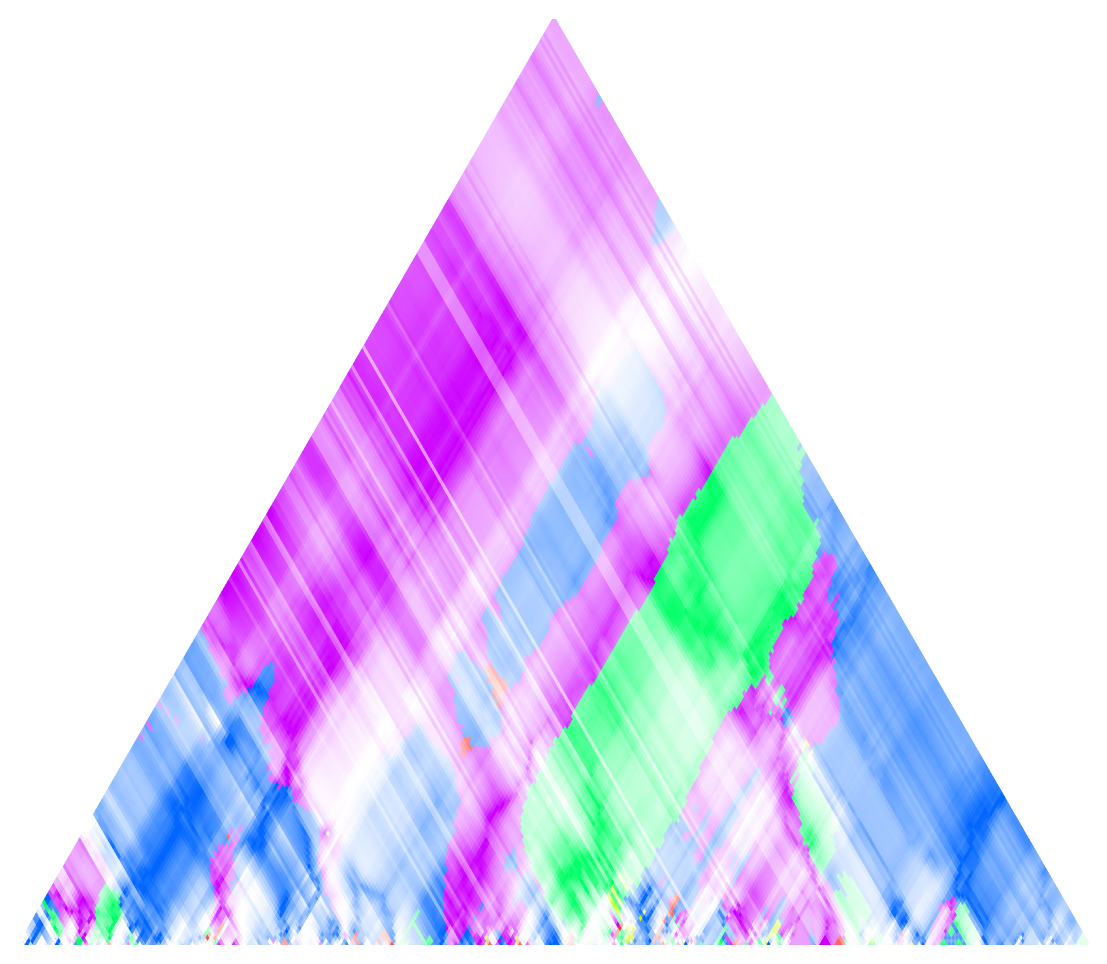

In [22]:
summary_colors = most_resonant2color(max_coeff, inv_entropy)
ws = Wavescape(summary_colors, width=width)
ws.draw()